<h1 align ='center', style = 'color:green' > Building model with countVectorizer tf-idf vectorizer

In [1]:
#vectorizer
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,HashingVectorizer

import numpy as np # linefinalar algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

#Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.metrics import classification_report 

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.
C:\Users\hanit\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hanit\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hanit\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hanit\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
data = pd.read_csv('Twitter_Data.csv', encoding= 'latin1')
# Keeping only the neccessary columns
data = data[['clean_text', 'category']]
data.head()

,clean_text,category
0,when modi promised âminimum government maxim...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [3]:
data = data.rename(columns = {'clean_text':"text", 'category':"sentiment"})

In [4]:
data.head()

,text,sentiment
0,when modi promised âminimum government maxim...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [5]:
# data['text'] = data['text'].astype('category')
# data['sentiment'] = data['sentiment'].astype('category')
data.shape

(162980, 2)

### Data understanding

In [6]:
data.isnull().sum()

text         4
sentiment    7
dtype: int64

In [7]:
data = data.dropna()

In [8]:
data.isnull().sum()

text         0
sentiment    0
dtype: int64

In [9]:
data.shape

(162969, 2)

In [10]:
# #converting tweets into lower:
# data['text'] = [str(tweets).strip().lower() for tweets in data['text']]

## Data cleaning

In [11]:
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [12]:
# for idx,row in data.iterrows():
#     row[0] = row[0].replace('rt',' ')

### Text preprocessing

In [13]:
from contractions import CONTRACTION_MAP
import unicodedata

In [14]:
#TExt Preprocess

#Contractions:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


#Scrub word removal:
def scrub_words(text):
    #Replace \xao characters in text
    text = re.sub('\xa0', ' ', text)
    
    #Replace non ascii / not words and digits
    text = re.sub("(\\W|\\d)",' ',text)
    
    #Replace new line characters and following text untill space
    text = re.sub('\n(\w*?)[\s]', '', text)
    
    #Remove html markup
    text = re.sub("<.*?>", ' ', text)
    return text

#Creating function object to convert ASCII character
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [15]:
#Applying preprocess functions:

data['text'] = data.text.apply(expand_contractions)
data['text'] = data.text.apply(scrub_words)
data['text'] = data.text.apply(remove_accented_chars)

In [16]:
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import text_to_word_sequence,Tokenizer
from nltk.corpus import stopwords

In [17]:
# stopwords:
stopWords = stopwords.words('english')
#add extra stop word
extra_stopWords = ['na','rt','http']
stopWords.extend(extra_stopWords)

In [18]:
# stemming.
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def Tokenizer_SWR_SL(_text, isLemamtize = False):
    tweets = text_to_word_sequence(_text)
    if isLemamtize:
        tweets = [lemmatizer.lemmatize(word) for word in tweets if not word in stopWords]
    else:
        tweets = [stemmer.stem(word) for word in tweets if not word in stopWords]    
    tweets = ' '.join(tweets)
    
    return tweets

In [19]:
data['text'] = data.text.apply(Tokenizer_SWR_SL,True)
data.head()

,text,sentiment
0,modi promis minimum govern maximum govern expe...,-1.0
1,talk nonsens continu drama vote modi,0.0
2,say vote modi welcom bjp told rahul main campa...,1.0
3,ask support prefix chowkidar name modi great s...,1.0
4,answer among power world leader today trump pu...,1.0


In [20]:
# convert the sentiments to numeric data.
def ConvertSentiments(_sentiment):
    cvt_sentiment = 0
    if _sentiment == 1:
        cvt_sentiment = 2
    elif _sentiment == 0:
        cvt_sentiment = 1
    else:
        cvt_sentiment = 0
        
    return cvt_sentiment

In [21]:
data['sentiment'] = data.sentiment.apply(ConvertSentiments)

In [22]:
data.sentiment.value_counts()

2    72249
1    55211
0    35509
Name: sentiment, dtype: int64

In [23]:
Y = data['sentiment']

## Vectorizing
### countVectorizer

In [24]:
# Count Vectorizer:
count_Vec = CountVectorizer(max_features=1000,ngram_range=(1,2))
X_CV = count_Vec.fit_transform(data.text).toarray()

### Tf-idf vectorizer

In [25]:
from sklearn.feature_selection import chi2

In [26]:
data.dtypes

text         object
sentiment     int64
dtype: object

### Text data visualization with Chi square

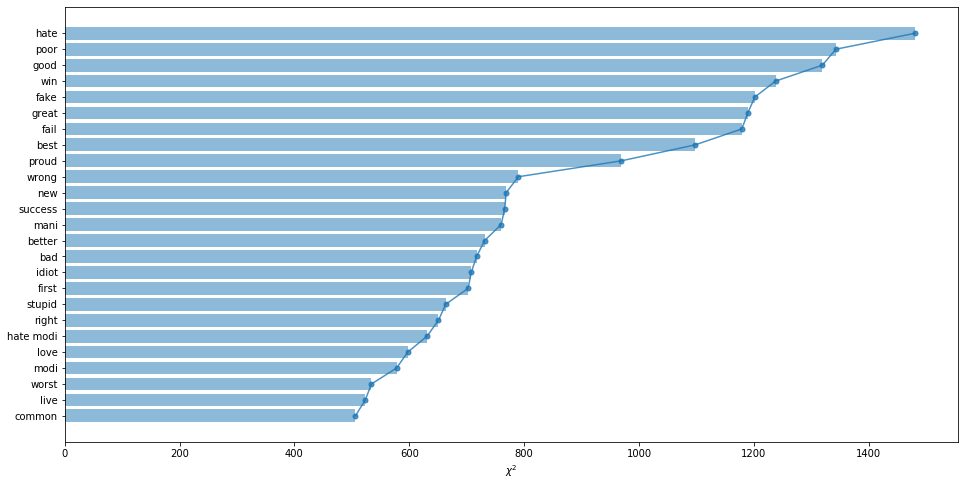

In [27]:
# TF-IDF
tfidf_Vec = TfidfVectorizer(max_features=1000,ngram_range=(1,2))
X_tfidf = tfidf_Vec.fit_transform(data.text)
y_tfidf = data.sentiment
chi2score = chi2(X_tfidf,y_tfidf)[0]

import matplotlib.pyplot as plt

#Plot
plt.figure(figsize=(16,8))
scores = list(zip(tfidf_Vec.get_feature_names(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-25:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show();

## Train-test split

In [28]:
X = tfidf_Vec.fit_transform(data.text).toarray()

In [29]:
X_trainTF, X_testTF, y_trainTF, y_testTF = train_test_split(X, Y , test_size=0.33, random_state=123)

In [30]:
print(X_trainTF.shape)
print(X_testTF.shape)

(109189, 1000)
(53780, 1000)


In [31]:
#X_trainTF, X_testTF, y_trainTF, y_testTF = train_test_split(X, Y , test_size=0.33, random_state=123)

#Countvectorizer train-test split
X_trainCV, X_testCV, y_trainCV, y_testCV = train_test_split(X_CV, Y , test_size=0.33, random_state=123)

In [32]:
X_trainCV.shape, X_testCV.shape


((109189, 1000), (53780, 1000))

## Model building

## Random Forest
### TF_idf:

In [33]:
# Create the model with 100 trees
Clf_RF = RandomForestClassifier(criterion='entropy',n_estimators=100,max_depth=100,bootstrap = True,max_features ='sqrt'
                                       ,min_samples_leaf=2,random_state=123)

In [34]:
%%time
Clf_RF.fit(X_trainTF, y_trainTF)

Wall time: 4min 39s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=100, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [35]:
RF_trainPredTF = Clf_RF.predict(X_trainTF)
print("confusion_matrix on train data\n",confusion_matrix(y_trainTF,RF_trainPredTF))
print("\n F1 SCORE = ",f1_score(y_trainTF, RF_trainPredTF, average="macro"))

confusion_matrix on train data
 [[14720  6245  2678]
 [  378 35668  1012]
 [  823  7754 39911]]

 F1 SCORE =  0.8111522552639729


In [36]:
RF_testPredTF = Clf_RF.predict(X_testTF)
print("confusion_matrix on test data\n",confusion_matrix(y_testTF,RF_testPredTF))
print("\n F1 SCORE = ",f1_score(y_testTF, RF_testPredTF, average="macro"))

confusion_matrix on test data
 [[ 5967  3317  2582]
 [  313 16828  1012]
 [ 1072  4366 18323]]

 F1 SCORE =  0.7373700616891278


### countVectorizer

In [37]:
Clf_RF.fit(X_trainCV, y_trainCV)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=100, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [38]:
RF_trainPredCV = Clf_RF.predict(X_trainCV)
print("confusion_matrix on train data\n",confusion_matrix(y_trainCV,RF_trainPredCV))
print("\n F1 SCORE = ",f1_score(y_trainCV, RF_trainPredCV, average="macro"))

confusion_matrix on train data
 [[14093  6538  3012]
 [  423 35569  1066]
 [ 1196  8400 38892]]

 F1 SCORE =  0.7930298895115561


In [39]:
RF_testPredCV = Clf_RF.predict(X_testCV)
print("confusion_matrix on test data\n",confusion_matrix(y_testCV,RF_testPredCV))
print("\n F1 SCORE = ",f1_score(y_testCV, RF_testPredCV, average="macro"))

confusion_matrix on test data
 [[ 6107  3461  2298]
 [  309 17061   783]
 [ 1118  4540 18103]]

 F1 SCORE =  0.7415789772767457


##  LSTM
### Tf_Idf:

In [40]:
max_fatures = 2000
tokenizer = Tokenizer(nb_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X,maxlen=100)

C:\Users\hanit\anaconda3\lib\site-packages\keras_preprocessing\text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [41]:
X.shape

(162969, 100)

In [42]:
embed_dim = 256
lstm_out = 196
max_fatures = 2000


model = Sequential()
model.add(Embedding(input_dim = max_fatures,output_dim = embed_dim,input_length = X.shape[1], dropout=0.2))
model.add(LSTM(lstm_out, dropout_U=0.2, dropout_W=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

C:\Users\hanit\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  import sys
C:\Users\hanit\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(196, dropout=0.2, recurrent_dropout=0.2)`
  


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 256)          512000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               355152    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 591       
Total params: 867,743
Trainable params: 867,743
Non-trainable params: 0
_________________________________________________________________
None


In [45]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 123)
X_test, X_val, Y_test, Y_val = train_test_split(X_test,Y_test, test_size = 0.5, random_state = 123)

In [46]:
%%time
batch_size = 64
model.fit(X_train, Y_train, nb_epoch = 7, batch_size=batch_size, verbose = 2)

C:\Users\hanit\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  



Epoch 1/7
 - 285s - loss: 0.5319 - accuracy: 0.7998
Epoch 2/7
 - 294s - loss: 0.4548 - accuracy: 0.8354
Epoch 3/7
 - 294s - loss: 0.4346 - accuracy: 0.8413
Epoch 4/7
 - 303s - loss: 0.4135 - accuracy: 0.8483
Epoch 5/7
 - 301s - loss: 0.3947 - accuracy: 0.8534
Epoch 6/7
 - 312s - loss: 0.3745 - accuracy: 0.8610
Epoch 7/7
 - 320s - loss: 0.3536 - accuracy: 0.8684
Wall time: 35min 11s


In [47]:
score,acc = model.evaluate(X_trainTF, Y_trainTF,batch_size = batch_size,verbose = 2)
print('Train Data')
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

Train Data
score: 0.30
acc: 0.89


In [48]:
score,acc = model.evaluate(X_testTF, Y_testTF,batch_size = batch_size, verbose = 2)
print('Test Data')
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

Test Data
score: 0.51
acc: 0.83


In [49]:

pos_cnt, neg_cnt, nut_cnt, pos_correct, neg_correct, nut_correct = 0, 0, 0, 0, 0, 0
for x in range(len(X_valTF)):
    
    result = model.predict(X_valTF[x].reshape(1,X_testTF.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_valTF[x]):
        if np.argmax(Y_valTF[x]) == 0:
            neg_correct += 1
        elif np.argmax(Y_valTF[x]) == 2:
            nut_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_valTF[x]) == 0:
        neg_cnt += 1
    elif np.argmax(Y_valTF[x]) == 2:
        nut_cnt += 1
    else:
        pos_cnt += 1

In [50]:
print('pos_acc', round(pos_correct/pos_cnt*100, 2), '%')
print('neg_acc', round(neg_correct/neg_cnt*100,2), "%")
print('Nuetral_acc', round(nut_correct/nut_cnt*100, 2), '%')

pos_acc 87.41 %
neg_acc 72.05 %
Nuetral_acc 85.11 %
